## Introduction

Sept 2021

Going to analyse all the IP21 tags for AL6 (packaging) 

Import some libraries

In [1]:
import configparser

Config = configparser.ConfigParser()

Config.read('settings.cfg')

def ConfigSectionMap(section):
    dict1 = {}
    options = Config.options(section)
    for option in options:
        try:
            dict1[option] = Config.get(section, option)
            if dict1[option] == -1:
                DebugPrint("skip: %s" % option)
        except:
            print("exception on %s!" % option)
            dict1[option] = None
    return dict1



dir_IP21 = ConfigSectionMap("SectionOne")['ip21']
dir_sanofi_share = ConfigSectionMap("SectionOne")['sanofi']
dir_alarms = ConfigSectionMap("SectionOne")['alarms']

print ("dir_sanofi_share is %s" % (dir_sanofi_share))
print ("dir_alarms is %s" % (dir_alarms))
print ("dir_IP21 is %s" % (dir_IP21))


dir_sanofi_share is C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Frankfurt sprint/SFD/
dir_alarms is C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Frankfurt sprint/SFD/Alarms_data/
dir_IP21 is C:/Users/mark_/Documents/McLaren2021/Sanofi/IP21/


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt


## tabIP21Tags.csv

This looks like a summary file created by Marco's process.  Don't read this in with the other csv files, but we might want to merge in some of this information, like DEFINITION




|Name|DEFINITION|IP_DESCRIPTION|IP_STEPPED|IP_DC_SIGNIFICANCE|IP_VALUE_FORMAT|IP_ENG_UNITS|IP_HIGH_HIGH_LIMIT|IP_HIGH_LIMIT|IP_LOW_LIMIT|IP_LOW_LOW_LIMIT|IP_PLANT_AREA|IP_REPOSITORY|IP_TAG_TYPE|
|----|----------|--------------|----------|------------------|---------------|------------|------------------|-------------|------------|----------------|-------------|-------------|-----------|
|36630901_CNTRB_ST6|IP_DiscreteAvDef|AL6 HH: Schlechtteile Station 6|Stepped|1|I11|Stck|400000|400000|0|0|AL6|TSK_DHIS_SFD|Discrete|
|36630901_ZA_MATNO|IP_TextAvDef|AL6 HH: ZA Materialnummer|||||||||AL6|TSK_DHIS_SFD|Text|
|36630901_PROD_MODE|IP_TextAvDef|AL6 HH: Produktionsmodus|||||||||AL6|TSK_DHIS_SFD|Text|
|36630901_BATCHACTIVE|IP_DiscreteAvDef|AL6 HH: Batch aktiv|Stepped|1|I 2|-|2|2|0|0|AL6|TSK_DHIS_SFD|Discrete|
|36630901_MATNO|IP_TextAvDef|AL6 HH: Materialnummer|||||||||AL6|TSK_DHIS_SFD|Text|




In [40]:
# read OEE Detailed Events report file for AL6 packaging machines
folder = 'IP21_data'

Files = []
df = []
df_IP21 = pd.DataFrame()

for filename in os.listdir( dir_sanofi_share + folder ):
    if filename.endswith('.csv') :
        if not (filename == 'tabIP21Tags.csv'):
            Files.append(filename)

Files.sort(key=str.lower)

Files


# Loop through all the files.
for filename in Files:
# filename = 'tabIP21Data_36630901_BATCHID.csv'
    path = os.path.join(dir_sanofi_share, folder, filename)
    # print (filename)
    df = pd.read_csv(path)
    df['Filename'] = filename
    df_IP21 = df_IP21.append(df)




In [54]:
# read in tabIP21Tags.csv
filename = 'tabIP21Tags.csv'
path = os.path.join(dir_sanofi_share, folder, filename)
df_IP21Tags = pd.DataFrame()
df_IP21Tags = pd.read_csv(path)

In [58]:
df_IP21 = df_IP21.merge(df_IP21Tags, on='Name', how='inner')

In [48]:
# convert dates to datetime format
df_IP21['IP_TREND_TIME'] = pd.to_datetime(df_IP21['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')

# convert dtypes to category to save memory
df_IP21 = df_IP21.astype({'Name': 'category',
#  'IP_TREND_VALUE': 'category',
 'IP_TREND_QLEVEL': 'category',
 'IP_TREND_QSTATUS': 'category',
 'Filename': 'category'
#  'DEFINITION': 'category',
#  'IP_DESCRIPTION': 'category',
#  'IP_STEPPED': 'category',
#  'IP_DC_SIGNIFICANCE': 'float64'
})

In [67]:
# read in the IP21 tag file to match up the tags with the machines
filename = 'IP.21 Tags AL6.xlsx'
path = os.path.join(dir_alarms, filename)
df_tags = pd.read_excel(path)


In [68]:
df_tags.rename(columns={'OPC Tag Name.1':'Name',
                        'PLT_Benennung':'Machine'}, inplace=True)
# df_tags.rename(columns={'OPC Tag Name.1':'Name'}, inplace=True)

df_merge columns made up as follows:

|#|Column|Dtype|||
|---|------|-----|---|---|
|0|Name|category|IP21 tag name|IP21 data|
|1|IP_TREND_VALUE|object|the main interest! - sensor value|IP21 data|
|2|IP_TREND_QLEVEL|category|another status - not sure|IP21 data|
|3|IP_TREND_QSTATUS|category|status of the sensor?|IP21 data|
|4|Filename|category|file data came from|I create this|
|5|DEFINITION|category|Discrete, Analague, Text (same as IP_TAG_TYPE)|marco summary file info|
|6|IP_DESCRIPTION|category|eg AL6 HH: Schlechtteile Station 6|marco summary file info|
|7|IP_STEPPED|category|null or 'Stepped'|marco summary file info|
|8|IP_DC_SIGNIFICANCE|float64||marco summary file info|
|9|IP_VALUE_FORMAT|category||marco summary file info|
|10|IP_ENG_UNITS|object||marco summary file info|
|11|IP_HIGH_HIGH_LIMIT|object||marco summary file info|
|12|IP_HIGH_LIMIT|object||marco summary file info|
|13|IP_LOW_LIMIT|float64||marco summary file info|
|14|IP_LOW_LOW_LIMIT|float64||marco summary file info|
|15|IP_PLANT_AREA|object|AL6|marco summary file info|
|16|IP_REPOSITORY|object|Sanofi storage area|marco summary file info|
|17|IP_TAG_TYPE|object|Discrete, Analague, Text (same info as DEFINITION)|marco summary file info|
|18|Machine|object|Full name of machine|marco summary file info|


In [69]:
df_merge = df_IP21.merge(df_tags[['Machine','Description. English','Name']], on='Name', how='inner')

In [72]:
df_merge.set_index('IP_TREND_TIME', inplace=True)

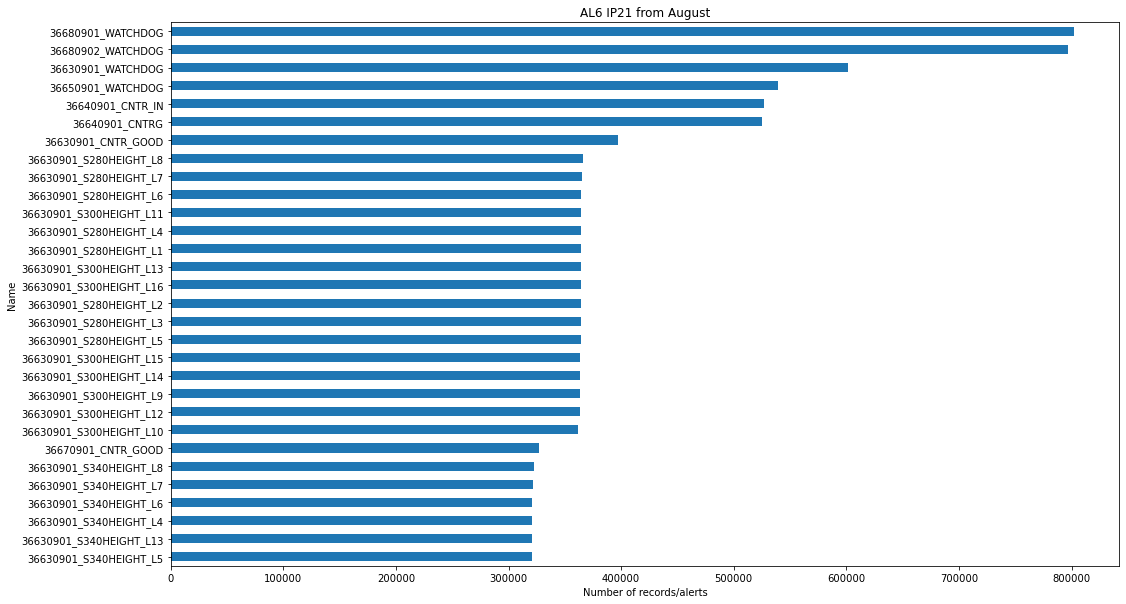

In [73]:
top30 = df_merge.groupby('Name')['IP_TREND_VALUE'].count().nlargest(30).sort_values(ascending=True)
top30.plot.barh(figsize=(17,10))
# plt.style.use('ggplot')
plt.title('AL6 IP21 from August')
plt.xlabel('Number of records/alerts')
plt.show()

In [74]:
# maybe we'll split into types of IP sensor?
df_height = df_merge[df_merge['Name'].str.contains('HEIGHT')]
df_watchdog = df_merge[df_merge['Name'].str.contains('WATCHDOG')]
df_cntr_good = df_merge[df_merge['Name'].str.contains('CNTR_GOOD')]
df_cntr_bad = df_cntr_good = df_merge[df_merge['Name'].str.contains('CNTR_BAD')]

In [76]:
# get the alarms.csv we produced earlier, which will say which ones are significant
filename = 'alarms.csv'
path = os.path.join(dir_IP21, filename)
# parse_dates and index datafram
df_alarms = pd.read_csv(path, encoding='UTF-8', index_col='Start', dayfirst=True)
df_alarms.index = pd.to_datetime(df_alarms.index,dayfirst=True)
df_alarms.sort_index(inplace=True)
df_alarms.drop(['Unnamed: 0'], axis=1, inplace=True)


In [140]:
#Define start and end date for August

start_date = '2021-08-01'
end_date = '2021-09-01'

days = datetime.strptime(end_date, '%Y-%m-%d')-datetime.strptime(start_date, '%Y-%m-%d')
# think this needs to be +1 day now that date filter is inclusive of end_date
ndays=days.days+1

df_alarms = df_alarms[(df_alarms.index >= start_date) & (df_alarms.index <= end_date) ]

# this throws a warning if the dates being used are not in the index, so not using it as this will be an error in future editions
# df_dates = df.loc[[start_date:end_date]


# df_dates=df_dates[df_dates['Filename'].str.contains(machine)]

In [151]:
df_merge['Machine'].unique()

array(['BDIS Signale Endverpackung Pester', 'BDIS Signale Montage HH',
       'BDIS Signale Kartonierer Schubert',
       'BDIS Signale Etikettierer Krones', 'BDIS Signale Single Unit SA'],
      dtype=object)

In [ ]:
df_merge.sample(50)

Error: Session cannot generate requests

In [149]:
# I think this is creating a merged dataframe of all IP21 data 5m either side of a significant alarm
df_alarms = df_alarms.sort_index()
df_merge = df_merge.sort_index()
df_alarms_ip21 = pd.merge_asof(df_merge, df_alarms, left_index=True, right_index=True, allow_exact_matches=True, tolerance=pd.Timedelta("5m"))

MemoryError: Unable to allocate 174. MiB for an array with shape (22768951,) and data type int64

In [134]:
alarms_10m = df_alarms.loc['2021-08-01 00:00':'2021-08-01 00:10']
ip21_10m = df_merge.loc['2021-08-01 00:00':'2021-08-01 00:10']



In [139]:
pd.merge_asof(ip21_10m, alarms_10m, left_index=True, right_index=True, allow_exact_matches=True, tolerance=pd.Timedelta("5m"))

,Name,IP_TREND_VALUE,IP_TREND_QLEVEL,IP_TREND_QSTATUS,Filename_x,DEFINITION,IP_DESCRIPTION,IP_STEPPED,IP_DC_SIGNIFICANCE,IP_VALUE_FORMAT,...,IP_REPOSITORY,IP_TAG_TYPE,Machine_x,Description. English,Message Text (English),Message Text,Duration,Filename_y,Machine_y,Significant
IP_TREND_TIME,,,,,,,,,,,,,,,,,,,,,
2021-08-01 00:00:01.900,36680902_WATCHDOG,-1,Good,Good,tabIP21Data_36680902_WATCHDOG.csv,IP_DiscreteAvDef,AL6 PAL:Watchdog,Stepped,1.0,I 2,...,TSK_DHIS_SFD,Discrete,BDIS Signale Endverpackung Pester,AL6 PAL: watchdog,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-01 00:00:01.900,36630901_WATCHDOG,0,Good,Good,tabIP21Data_36630901_WATCHDOG.csv,IP_DiscreteAvDef,AL6 HH: Watchdog,Stepped,1.0,I 2,...,TSK_DHIS_SFD,Discrete,BDIS Signale Montage HH,AL6 HH: watchdog,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-01 00:00:01.900,36680901_WATCHDOG,0,Good,Good,tabIP21Data_36680901_WATCHDOG.csv,IP_DiscreteAvDef,AL6 UVP:Watchdog,Stepped,1.0,I 2,...,TSK_DHIS_SFD,Discrete,BDIS Signale Endverpackung Pester,AL6 RRP: watchdog,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-01 00:00:02.900,36630901_WATCHDOG,-1,Good,Good,tabIP21Data_36630901_WATCHDOG.csv,IP_DiscreteAvDef,AL6 HH: Watchdog,Stepped,1.0,I 2,...,TSK_DHIS_SFD,Discrete,BDIS Signale Montage HH,AL6 HH: watchdog,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-01 00:00:02.900,36680902_WATCHDOG,0,Good,Good,tabIP21Data_36680902_WATCHDOG.csv,IP_DiscreteAvDef,AL6 PAL:Watchdog,Stepped,1.0,I 2,...,TSK_DHIS_SFD,Discrete,BDIS Signale Endverpackung Pester,AL6 PAL: watchdog,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01 00:10:55.900,36680902_WATCHDOG,-1,Good,Good,tabIP21Data_36680902_WATCHDOG.csv,IP_DiscreteAvDef,AL6 PAL:Watchdog,Stepped,1.0,I 2,...,TSK_DHIS_SFD,Discrete,BDIS Signale Endverpackung Pester,AL6 PAL: watchdog,Device lock was closed by: conveyor belts,Devicesperre wurde geschlossen durch: Transpor...,NaN,AL6Audit Trail 000000 2021-08-01 K747B14.csv,AL6_Etikettierer,No
2021-08-01 00:10:55.900,36650901_WATCHDOG,0,Good,Good,tabIP21Data_36650901_WATCHDOG.csv,IP_DiscreteAvDef,AL6 SCH: PU Watchdog,Stepped,1.0,I 2,...,TSK_DHIS_SFD,Discrete,BDIS Signale Kartonierer Schubert,AL6 SCH: PU Watchdog,Device lock was closed by: conveyor belts,Devicesperre wurde geschlossen durch: Transpor...,NaN,AL6Audit Trail 000000 2021-08-01 K747B14.csv,AL6_Etikettierer,No
2021-08-01 00:10:58.000,36680902_WATCHDOG,0,Good,Good,tabIP21Data_36680902_WATCHDOG.csv,IP_DiscreteAvDef,AL6 PAL:Watchdog,Stepped,1.0,I 2,...,TSK_DHIS_SFD,Discrete,BDIS Signale Endverpackung Pester,AL6 PAL: watchdog,Device lock was closed by: conveyor belts,Devicesperre wurde geschlossen durch: Transpor...,NaN,AL6Audit Trail 000000 2021-08-01 K747B14.csv,AL6_Etikettierer,No


In [88]:
# let's write this out
filename = 'df_alarms_ip21.csv'
path = os.path.join(dir_alarms, filename)
df_alarms_ip21.to_csv(path)